In [1]:
from tqdm import tqdm
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import *
from keras.applications.efficientnet import *
from keras.preprocessing.image import ImageDataGenerator
from models import *
import os
import warnings

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams["figure.dpi"] = 120
image_dimension = (224, 224)
epochs=100
batch_size = 32
epoch_index = [i for i in range(1, epochs+1)]

#### Check whether GPU is available

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Load Data, Label for prediction (currently use one dataset (Brain MRI Data2))

In [4]:
labels = {"glioma":1, "meningioma":2, "notumor":0, "pituitary":3}
dir_name = "MRI_DATA"
image_list = list()
truth_list = list()

for label, index in labels.items():
    path = os.path.join("Brain_MRI_data2", dir_name, label)
    images = os.listdir(path)
    for image in tqdm(images):
        current_image = cv2.imread(os.path.join(path, image))
        current_image = cv2.resize(current_image, image_dimension)
        image_list.append(current_image)
        truth_list.append(index)

features = np.array(image_list)/255.0 # rescale
labels = tf.keras.utils.to_categorical(truth_list)

100%|██████████| 1757/1757 [00:03<00:00, 495.93it/s]


In [5]:
print("image dimension: {}, label dimension: {}".format(features.shape, labels.shape))

image dimension: (7023, 224, 224, 3), label dimension: (7023, 4)


#### Define model saving function

In [6]:
def save_model(model_name):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join("trained_model_weights", model_name),
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')
    return [checkpoint]

#### Split dataset into train, validation and test set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42, shuffle=True)
train_generator = ImageDataGenerator(validation_split=0.25)
test_generator = ImageDataGenerator()

train_df = train_generator.flow(X_train, y_train, batch_size=batch_size, subset="training")
validation_df = train_generator.flow(X_train, y_train, batch_size=batch_size, subset="validation")
test_df = train_generator.flow(X_test, y_test, batch_size=batch_size)

#### Use a simple CNN

In [8]:
simple_cnn_path = "simple_cnn.hdf5"
model_simple_cnn = simple_cnn()
model_simple_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_simple_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

In [9]:
simple_cnn_history = model_simple_cnn.fit(train_df,
                                          epochs=epochs,
                                          verbose=1,
                                          validation_data=validation_df,
                                          callbacks=save_model(simple_cnn_path))

Epoch 1/100
181/181 [==============================] - 11s 22ms/step - loss: 1.3006 - accuracy: 0.4139 - val_loss: 1.2007 - val_accuracy: 0.6846

Epoch 00001: val_accuracy improved from -inf to 0.68465, saving model to trained_model_weights\simple_cnn.hdf5
Epoch 2/100
181/181 [==============================] - 3s 19ms/step - loss: 1.1961 - accuracy: 0.4678 - val_loss: 1.1192 - val_accuracy: 0.6582

Epoch 00002: val_accuracy did not improve from 0.68465
Epoch 3/100
181/181 [==============================] - 3s 19ms/step - loss: 1.1412 - accuracy: 0.4754 - val_loss: 1.0336 - val_accuracy: 0.7002

Epoch 00003: val_accuracy improved from 0.68465 to 0.70021, saving model to trained_model_weights\simple_cnn.hdf5
Epoch 4/100
181/181 [==============================] - 3s 19ms/step - loss: 1.0859 - accuracy: 0.4947 - val_loss: 0.9710 - val_accuracy: 0.7204

Epoch 00004: val_accuracy improved from 0.70021 to 0.72044, saving model to trained_model_weights\simple_cnn.hdf5
Epoch 5/100
181/181 [====

In [9]:
model_simple_cnn.load_weights(os.path.join("trained_model_weights", simple_cnn_path))
model_simple_cnn.evaluate(test_df)

55/55 [==============================] - 6s 16ms/step - loss: 0.0583 - accuracy: 0.9852


[0.05830441787838936, 0.9851936101913452]

Text(0.5, 1.0, 'Simple CNN Model')

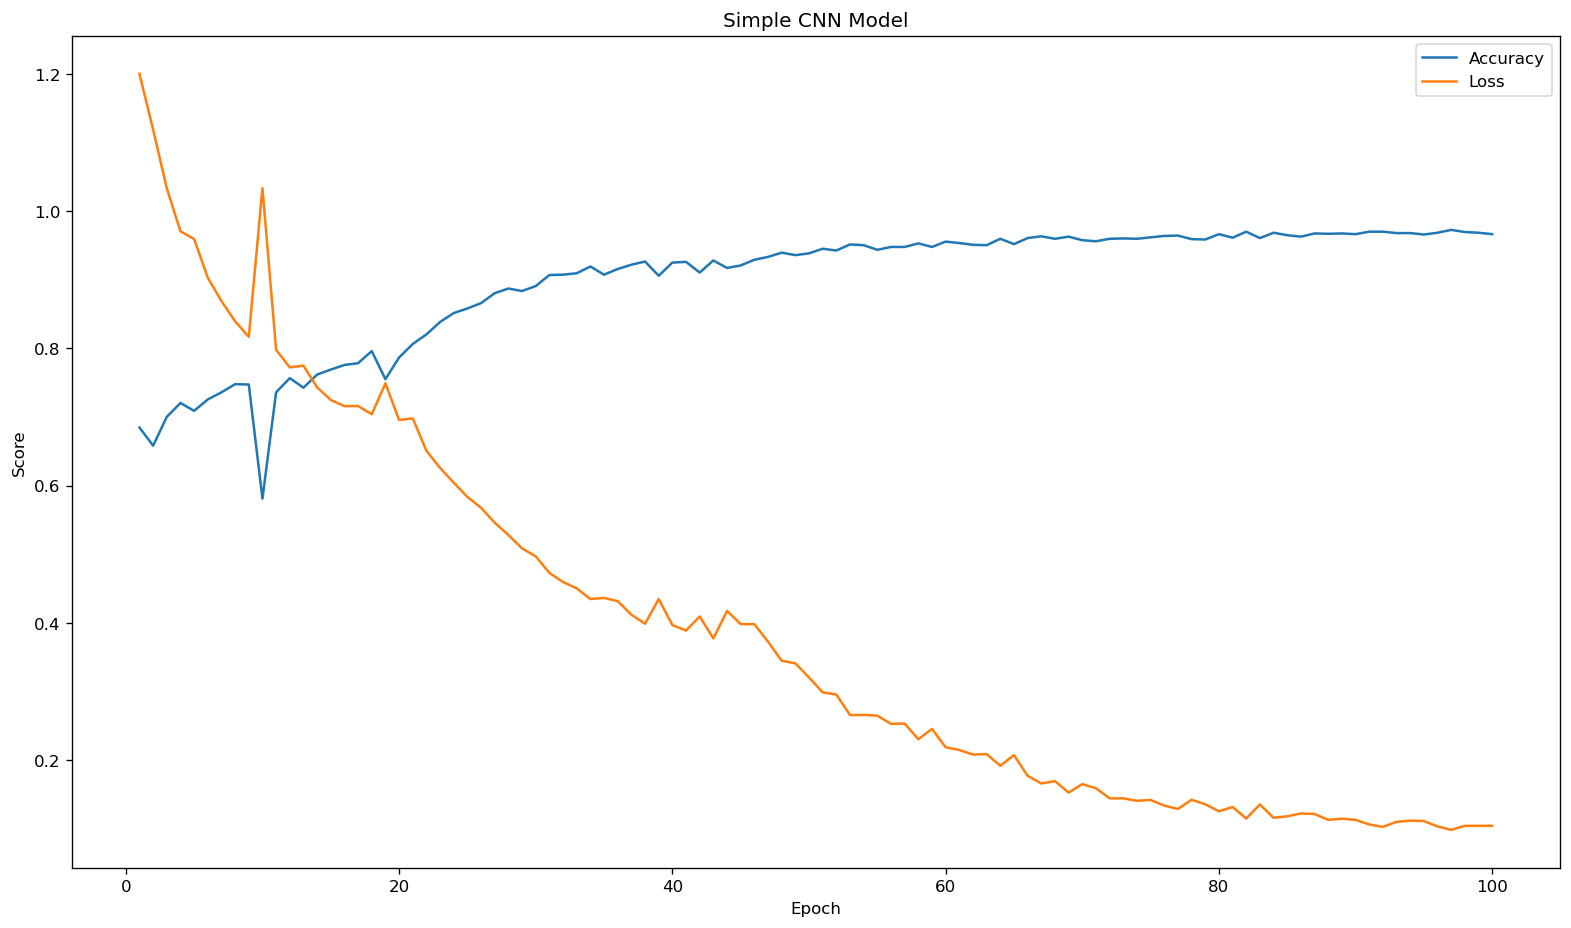

In [11]:
simple_cnn_result = pd.DataFrame({"Accuracy": simple_cnn_history.history["val_accuracy"],
                                  "Loss": simple_cnn_history.history["val_loss"]}, index=epoch_index)
simple_cnn_result.to_csv("Simple_CNN_result.csv")
ax_simple_cnn = simple_cnn_result.plot.line(figsize=(16, 9))
ax_simple_cnn.set_xlabel("Epoch")
ax_simple_cnn.set_ylabel("Score")
ax_simple_cnn.set_title("Simple CNN Model")

#### Using Resnet50

In [10]:
model_resnet_path = "resnet50.hdf5"
model_resnet = resnet_50()
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
input_2 (InputLayer)         multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               256256    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 25,893,996
Trainable params: 25,840,876
Non-trainable params: 53,120
_____________________________________

In [13]:
model_resnet_history = model_resnet.fit(train_df,
                 epochs=epochs,
                 verbose=1,
                 validation_data=validation_df,
                 callbacks=save_model(model_resnet_path))

Epoch 1/100
181/181 [==============================] - 27s 117ms/step - loss: 1.3661 - accuracy: 0.5412 - val_loss: 1.3846 - val_accuracy: 0.4009

Epoch 00001: val_accuracy improved from -inf to 0.40093, saving model to trained_model_weights\resnet50.hdf5
Epoch 2/100
181/181 [==============================] - 19s 103ms/step - loss: 1.3176 - accuracy: 0.7728 - val_loss: 1.3811 - val_accuracy: 0.2614

Epoch 00002: val_accuracy did not improve from 0.40093
Epoch 3/100
181/181 [==============================] - 19s 103ms/step - loss: 1.2761 - accuracy: 0.8885 - val_loss: 1.3719 - val_accuracy: 0.2910

Epoch 00003: val_accuracy did not improve from 0.40093
Epoch 4/100
181/181 [==============================] - 19s 103ms/step - loss: 1.2392 - accuracy: 0.9438 - val_loss: 1.3343 - val_accuracy: 0.5161

Epoch 00004: val_accuracy improved from 0.40093 to 0.51608, saving model to trained_model_weights\resnet50.hdf5
Epoch 5/100
181/181 [==============================] - 19s 103ms/step - loss: 1.2

Text(0.5, 1.0, 'Resnet50 Model')

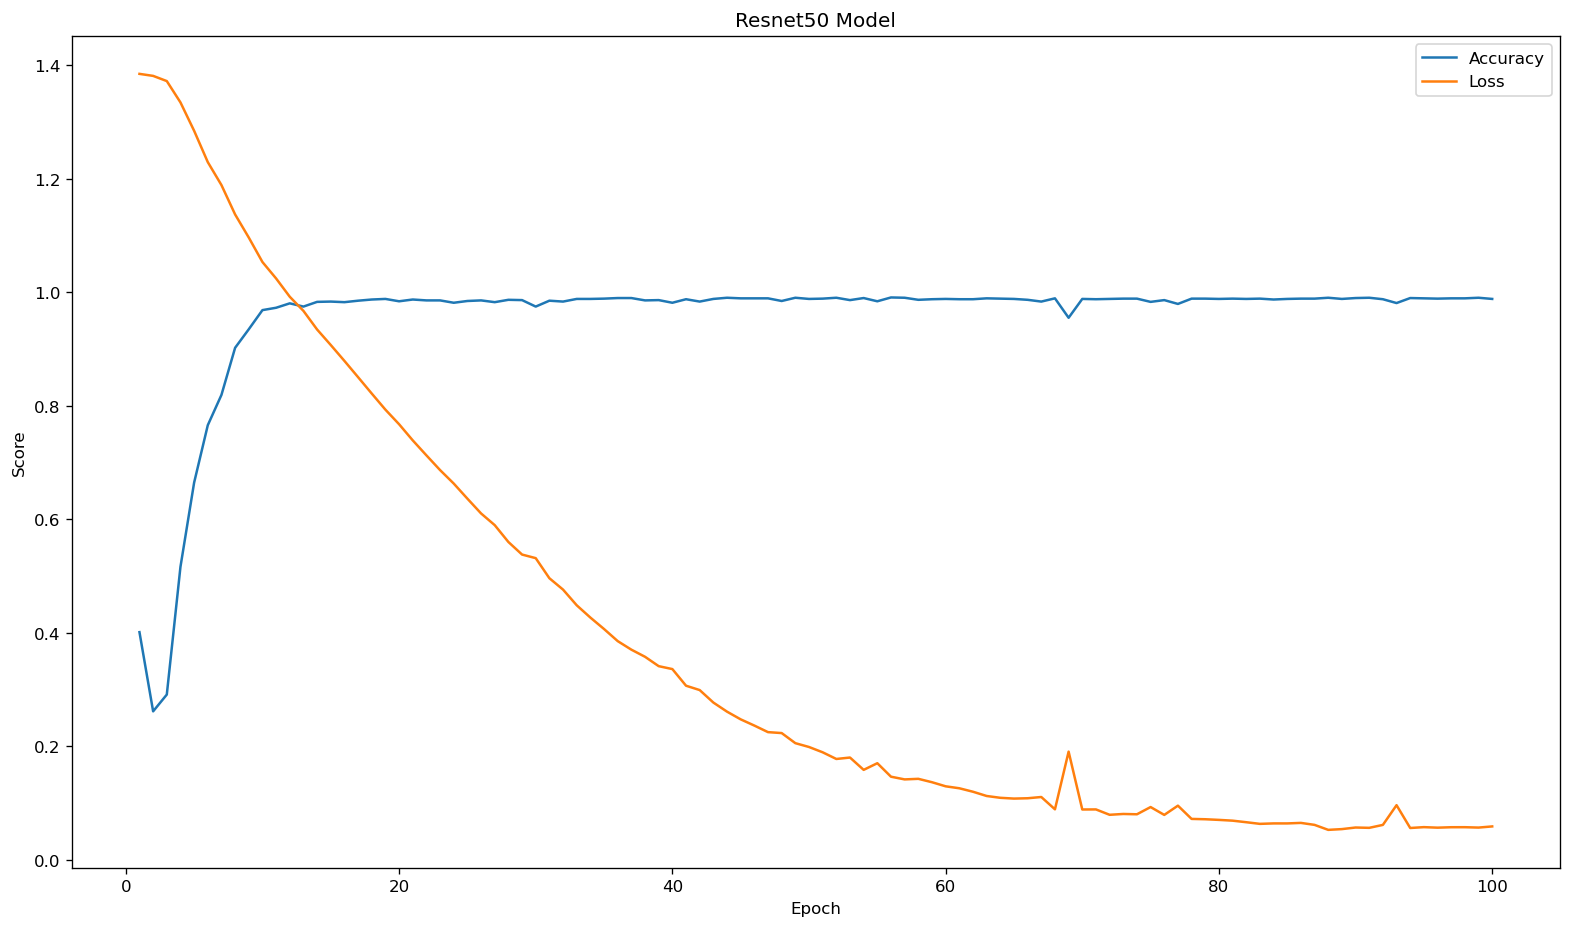

In [14]:
epoch_index = [i for i in range(1, epochs+1)]
resnet_result = pd.DataFrame({"Accuracy": model_resnet_history.history["val_accuracy"],
                                  "Loss": model_resnet_history.history["val_loss"]}, index=epoch_index)
resnet_result.to_csv("resnet_result.csv")
ax_resnet = resnet_result.plot.line(figsize=(16, 9))
ax_resnet.set_xlabel("Epoch")
ax_resnet.set_ylabel("Score")
ax_resnet.set_title("Resnet50 Model")

In [11]:
model_resnet.load_weights(os.path.join("trained_model_weights", model_resnet_path))
model_resnet.evaluate(test_df)

55/55 [==============================] - 4s 42ms/step - loss: 0.1287 - accuracy: 0.9966


[0.1286824494600296, 0.9965831637382507]

#### Using VGG-16

In [14]:
model_vgg16_path = "vgg16.hdf5"
model_vgg16 = vgg_16()
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1000)              138357544 
_________________________________________________________________
flatten_3 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               128128    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 516       
Total params: 138,486,188
Trainable params: 138,486,188
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_vgg16_history = model_vgg16.fit(train_df,
                                      verbose=1,
                                      epochs=epochs,
                                      validation_data=validation_df,
                                      callbacks=save_model(model_vgg16_path))

Epoch 1/100
181/181 [==============================] - 33s 148ms/step - loss: 1.3606 - accuracy: 0.3987 - val_loss: 1.3494 - val_accuracy: 0.4793

Epoch 00001: val_accuracy improved from -inf to 0.47925, saving model to trained_model_weights\vgg16.hdf5
Epoch 2/100
181/181 [==============================] - 22s 123ms/step - loss: 1.3399 - accuracy: 0.6069 - val_loss: 1.3307 - val_accuracy: 0.8662

Epoch 00002: val_accuracy improved from 0.47925 to 0.86618, saving model to trained_model_weights\vgg16.hdf5
Epoch 3/100
181/181 [==============================] - 22s 123ms/step - loss: 1.3205 - accuracy: 0.7555 - val_loss: 1.3124 - val_accuracy: 0.8942

Epoch 00003: val_accuracy improved from 0.86618 to 0.89419, saving model to trained_model_weights\vgg16.hdf5
Epoch 4/100
181/181 [==============================] - 22s 123ms/step - loss: 1.3026 - accuracy: 0.8358 - val_loss: 1.2939 - val_accuracy: 0.9201

Epoch 00004: val_accuracy improved from 0.89419 to 0.92012, saving model to trained_mode

Text(0.5, 1.0, 'VGG16 Model')

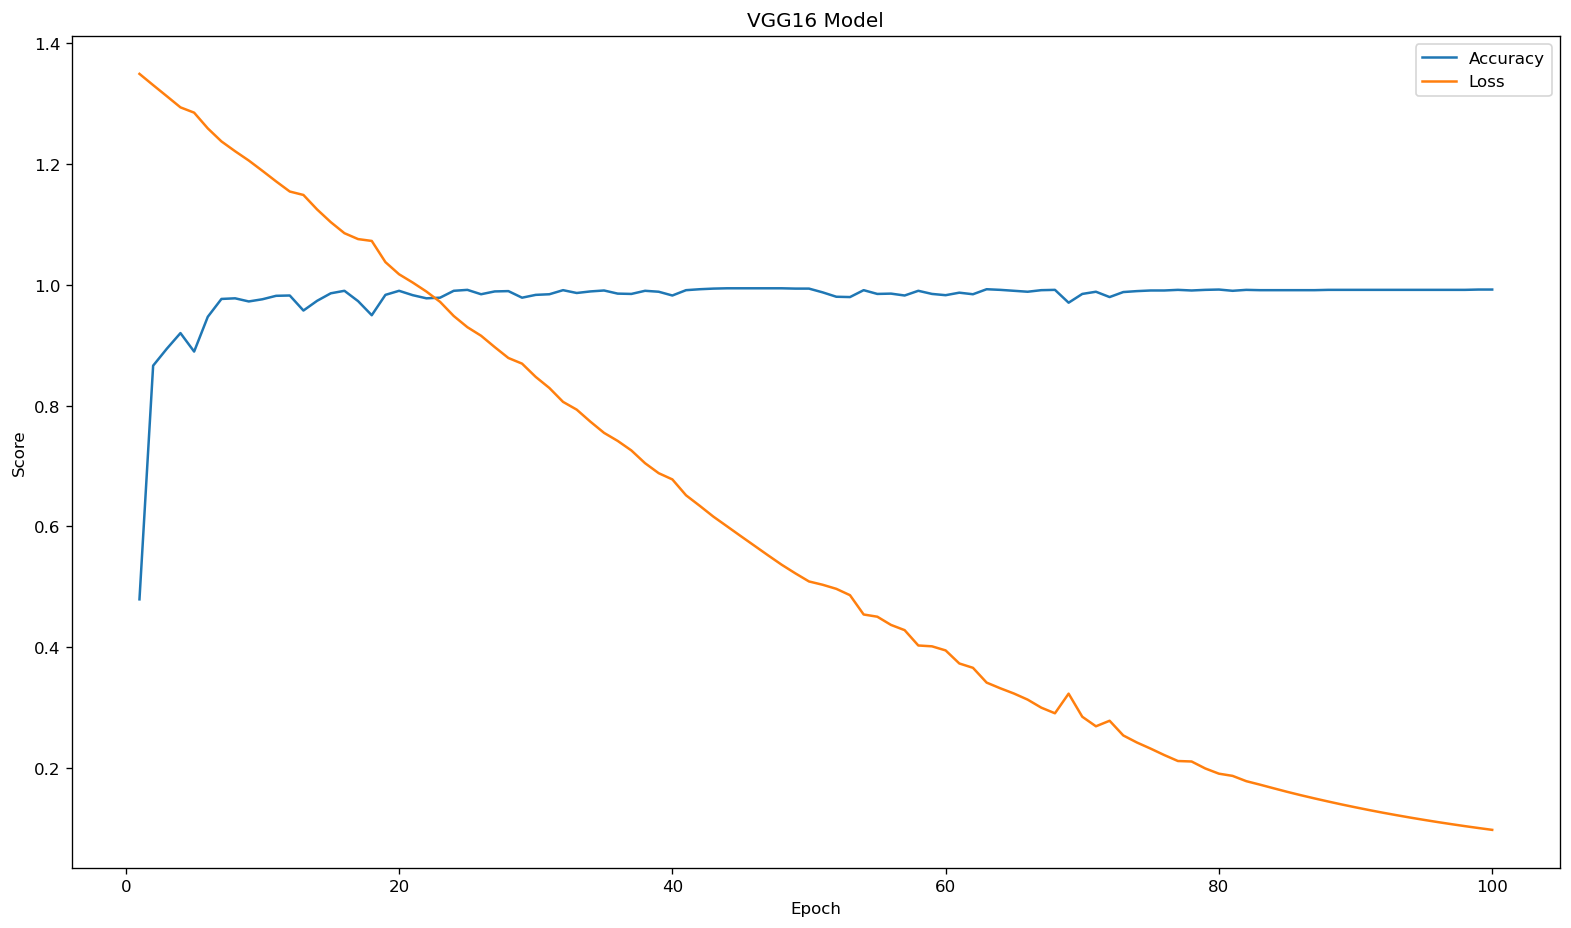

In [18]:
vgg16_result = pd.DataFrame({"Accuracy": model_vgg16_history.history["val_accuracy"],
                             "Loss": model_vgg16_history.history["val_loss"]}, index=epoch_index)
vgg16_result.to_csv("vgg16_result.csv")
ax_vgg16 = vgg16_result.plot.line(figsize=(16, 9))
ax_vgg16.set_xlabel("Epoch")
ax_vgg16.set_ylabel("Score")
ax_vgg16.set_title("VGG16 Model")

In [15]:
model_vgg16.load_weights(os.path.join("trained_model_weights", model_vgg16_path))
model_vgg16.evaluate(test_df)

55/55 [==============================] - 3s 38ms/step - loss: 0.5957 - accuracy: 0.9954


[0.5957022905349731, 0.9954441785812378]

#### Using VGG-19

In [12]:
model_vgg19_path = "vgg19.hdf5"
model_vgg19 = vgg_19()
model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model_vgg19.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1000)              143667240 
_________________________________________________________________
flatten_2 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               128128    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
Total params: 143,795,884
Trainable params: 143,795,884
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_vgg19_history = model_vgg19.fit(train_df,
                                      verbose=1,
                                      epochs=epochs,
                                      validation_data=validation_df,
                                      callbacks=save_model(model_vgg19_path))

Epoch 1/100
181/181 [==============================] - 27s 143ms/step - loss: 1.3670 - accuracy: 0.4194 - val_loss: 1.3587 - val_accuracy: 0.6043

Epoch 00001: val_accuracy improved from -inf to 0.60425, saving model to trained_model_weights\vgg19.hdf5
Epoch 2/100
181/181 [==============================] - 26s 142ms/step - loss: 1.3506 - accuracy: 0.4731 - val_loss: 1.3451 - val_accuracy: 0.4927

Epoch 00002: val_accuracy did not improve from 0.60425
Epoch 3/100
181/181 [==============================] - 26s 142ms/step - loss: 1.3412 - accuracy: 0.4795 - val_loss: 1.3354 - val_accuracy: 0.5000

Epoch 00003: val_accuracy did not improve from 0.60425
Epoch 4/100
181/181 [==============================] - 26s 143ms/step - loss: 1.3346 - accuracy: 0.4847 - val_loss: 1.3280 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.60425
Epoch 5/100
181/181 [==============================] - 26s 142ms/step - loss: 1.3274 - accuracy: 0.4806 - val_loss: 1.3224 - val_accuracy: 0.

Text(0.5, 1.0, 'VGG16 Model')

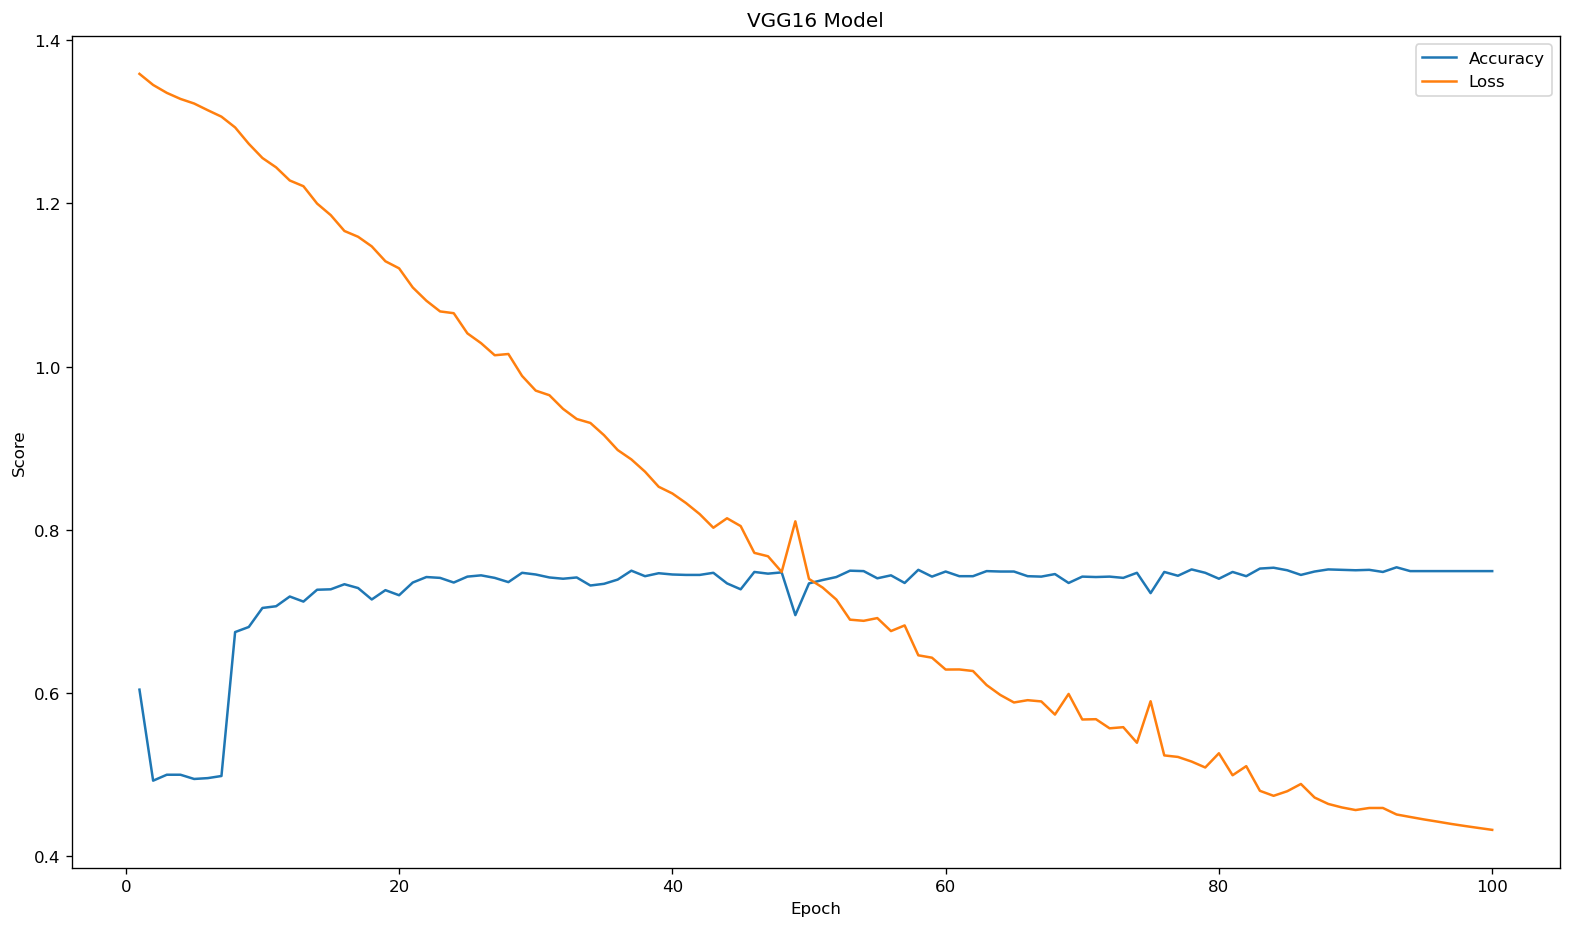

In [22]:
vgg19_result = pd.DataFrame({"Accuracy": model_vgg19_history.history["val_accuracy"],
                             "Loss": model_vgg19_history.history["val_loss"]}, index=epoch_index)
vgg19_result.to_csv("vgg19_result.csv")
ax_vgg19 = vgg19_result.plot.line(figsize=(16, 9))
ax_vgg19.set_xlabel("Epoch")
ax_vgg19.set_ylabel("Score")
ax_vgg19.set_title("VGG16 Model")

In [13]:
model_vgg19.load_weights(os.path.join("trained_model_weights", model_vgg19_path))
model_vgg19.evaluate(test_df)

55/55 [==============================] - 5s 60ms/step - loss: 2.7804 - accuracy: 0.7454


[2.7804408073425293, 0.7454441785812378]

#### Using efficientnet B0

In [17]:
base_efficientnet = EfficientNetB3(include_top=False, weights="imagenet", pooling="max")
model_efficientnetB0 = models.Sequential()
model_efficientnetB0.add(base_efficientnet)
model_efficientnetB0.add(layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
# model_efficientnetB0.add(layers.Dense(256, kernel_regularizer=regularizers.l2(l=0.016),
#                                         activity_regularizer=regularizers.l1(0.006),
#                            bias_regularizer=regularizers.l1(0.006), activation='relu'))
model_efficientnetB0.add(layers.Dropout(0.5))
model_efficientnetB0.add(layers.Dense(4, activation='softmax'))
model_efficientnetB0_path = "efficientnetB0.hdf5"
# model_efficientnetB0 = efficientnet(EfficientNetB3(include_top=False, weights="imagenet", pooling="max"))
model_efficientnetB0.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model_efficientnetB0.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
batch_normalization_1 (Batch (None, 1536)              6144      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 6148      
Total params: 10,795,827
Trainable params: 10,705,452
Non-trainable params: 90,375
_________________________________________________________________


In [18]:
model_efficientnetB0_history = model_efficientnetB0.fit(train_df,
                                      verbose=1,
                                      epochs=epochs,
                                      validation_data=validation_df,
                                      callbacks=save_model(model_efficientnetB0_path))

Epoch 1/100
124/124 [==============================] - 49s 285ms/step - loss: 1.7977 - accuracy: 0.4174 - val_loss: 2.6999 - val_accuracy: 0.2964

Epoch 00001: val_accuracy improved from -inf to 0.29635, saving model to trained_model_weights\efficientnetB0.hdf5
Epoch 2/100
124/124 [==============================] - 32s 262ms/step - loss: 1.0380 - accuracy: 0.6391 - val_loss: 3.3752 - val_accuracy: 0.2599

Epoch 00002: val_accuracy did not improve from 0.29635
Epoch 3/100
124/124 [==============================] - 32s 258ms/step - loss: 0.8499 - accuracy: 0.7135 - val_loss: 2.1043 - val_accuracy: 0.3055

Epoch 00003: val_accuracy improved from 0.29635 to 0.30547, saving model to trained_model_weights\efficientnetB0.hdf5
Epoch 4/100
124/124 [==============================] - 31s 249ms/step - loss: 0.7037 - accuracy: 0.7553 - val_loss: 2.1421 - val_accuracy: 0.3100

Epoch 00004: val_accuracy improved from 0.30547 to 0.31003, saving model to trained_model_weights\efficientnetB0.hdf5
Epoch 

KeyboardInterrupt: 

Text(0.5, 1.0, 'efficientnetB3 Model')

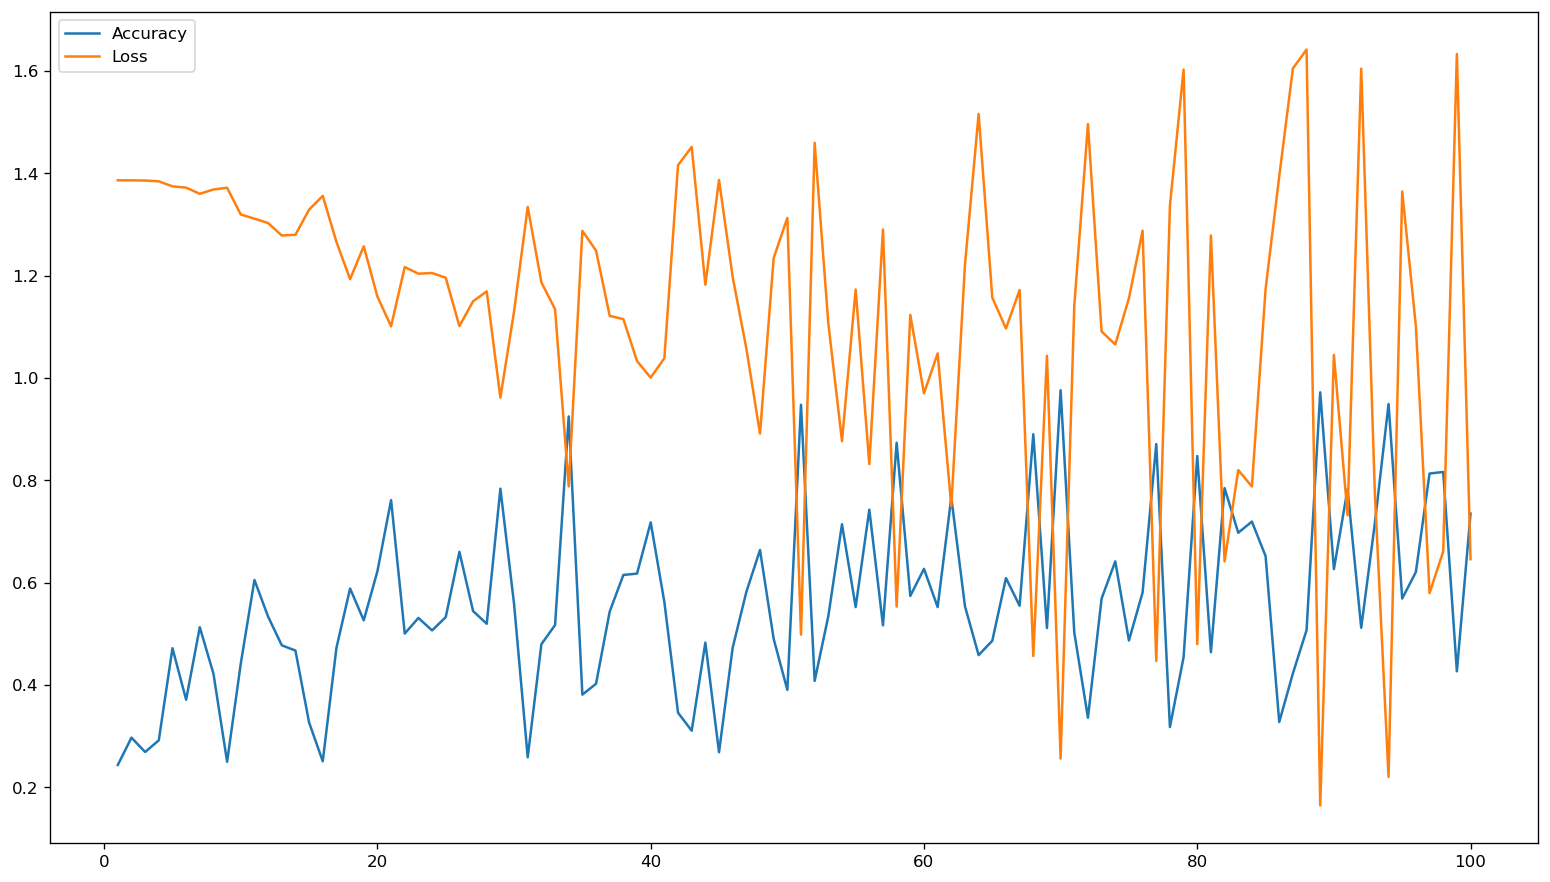

In [26]:
efficientnetB0_result = pd.DataFrame({"Accuracy": model_efficientnetB0_history.history["val_accuracy"],
                             "Loss": model_efficientnetB0_history.history["val_loss"]}, index=epoch_index)
efficientnetB0_result.to_csv("efficientnetB0_result.csv")
ax_efficientnetB3 = efficientnetB0_result.plot.line(figsize=(16, 9))
ax_vgg19.set_xlabel("Epoch")
ax_vgg19.set_ylabel("Score")
ax_vgg19.set_title("efficientnetB0 Model")

In [27]:
model_efficientnetB0.load_weights(os.path.join("trained_model_weights", model_efficientnetB0_path))
model_efficientnetB0.evaluate(test_df)

81/81 [==============================] - 2s 25ms/step - loss: 0.2667 - accuracy: 0.9677


[0.26667559146881104, 0.967729389667511]

<AxesSubplot:>

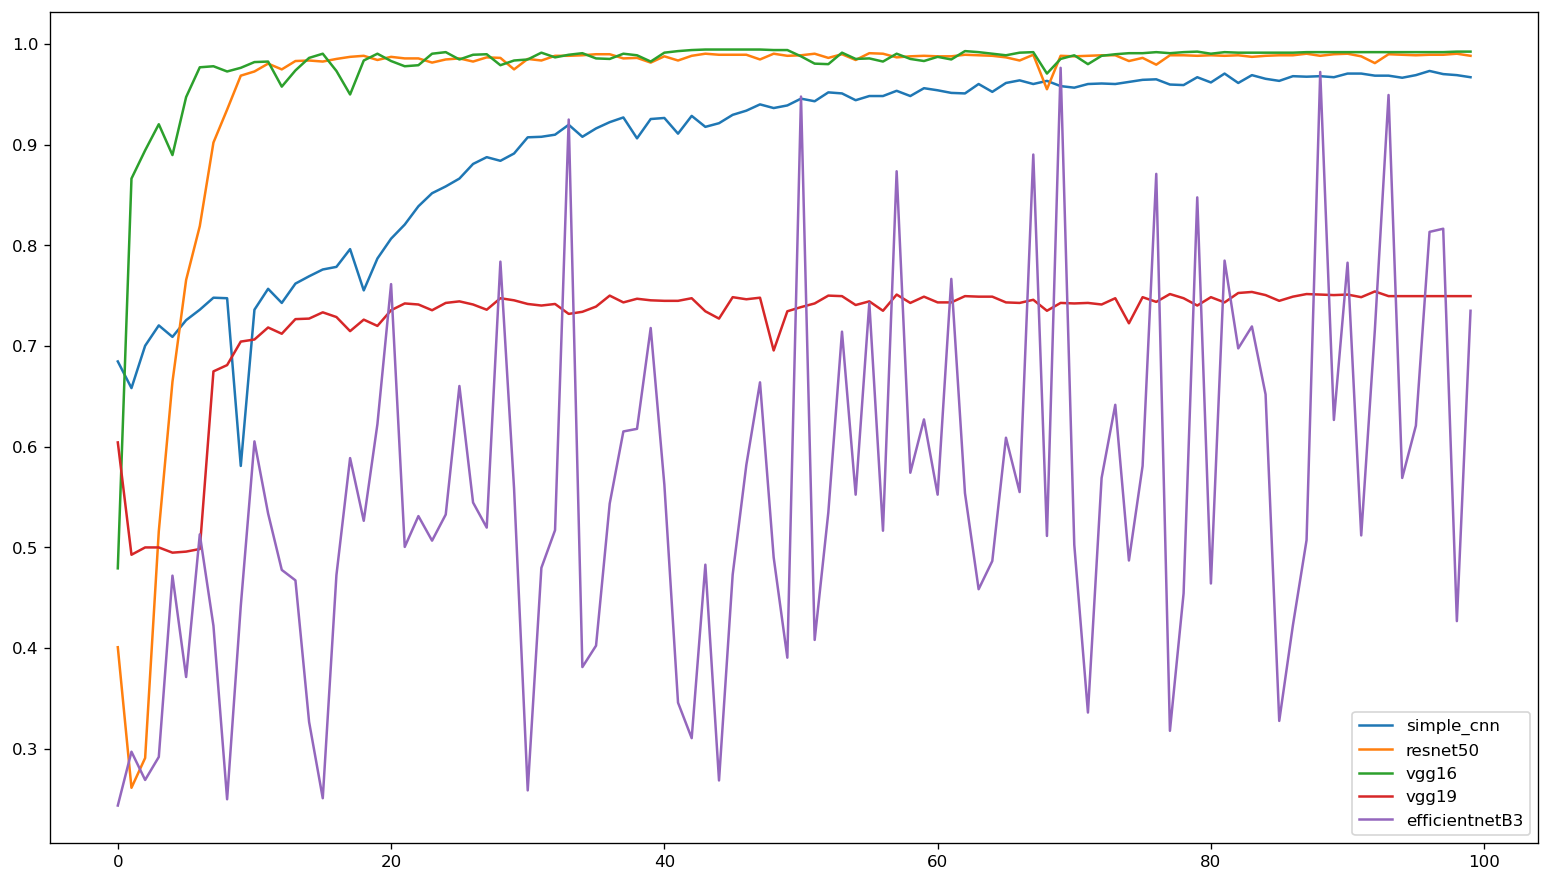

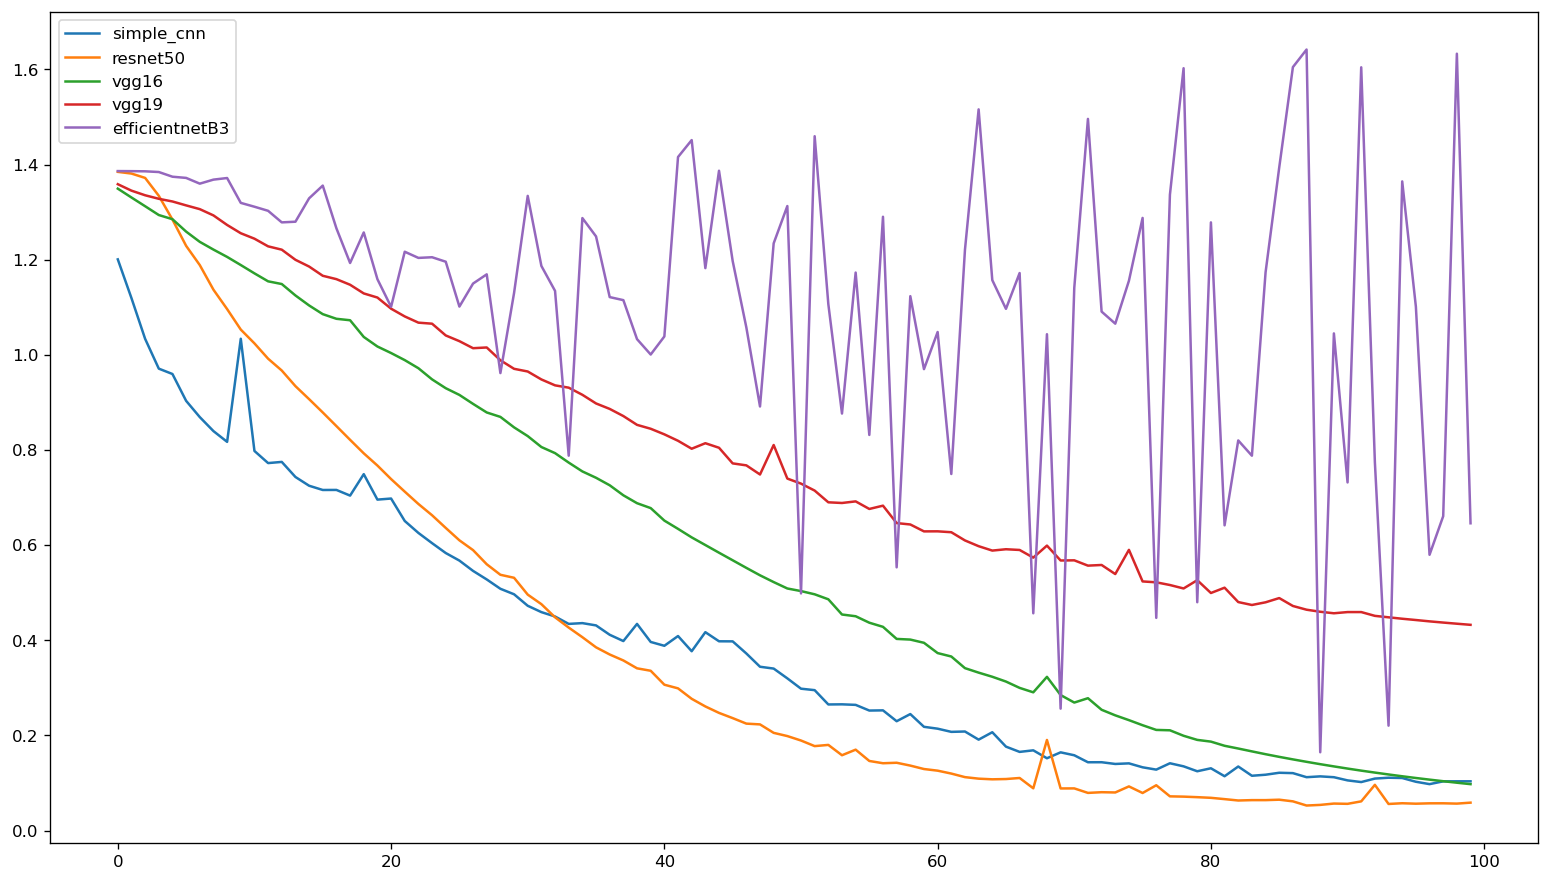

In [28]:
model_accuracy_compare = pd.DataFrame({"simple_cnn": simple_cnn_history.history["val_accuracy"],
                                       "resnet50": model_resnet_history.history["val_accuracy"],
                                       "vgg16": model_vgg16_history.history["val_accuracy"],
                                       "vgg19": model_vgg19_history.history["val_accuracy"],
                                       "efficientnetB3": model_efficientnetB0_history.history["val_accuracy"]})

model_accuracy_compare.plot.line(figsize=(16, 9))


model_loss_compare = pd.DataFrame({"simple_cnn": simple_cnn_history.history["val_loss"],
                                   "resnet50": model_resnet_history.history["val_loss"],
                                   "vgg16": model_vgg16_history.history["val_loss"],
                                   "vgg19": model_vgg19_history.history["val_loss"],
                                   "efficientnetB3": model_efficientnetB0_history.history["val_loss"]})

model_loss_compare.plot.line(figsize=(16, 9))